In [5]:
import pandas as pd
import requests
import time
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from tqdm import tqdm

### Premier dataset

In [6]:
url = 'https://projet-incendie.s3.eu-west-3.amazonaws.com/Incendies_2007_2024.csv'

df = pd.read_csv(url, sep=';', encoding='utf-8', skiprows=3)
pd.set_option('display.max_columns', None)

print(df.head(10))
print(df.shape)

   Année  Numéro Département Code INSEE      Nom de la commune  \
0   2014    6330          66      66190      Salses-le-Château   
1   2014    2369          06      06074              Lantosque   
2   2014    2546          2A      2A139                  Lecci   
3   2014       6          65      65173                Esterre   
4   2014    8243          2B      2B058                 Canari   
5   2014       7          65      65233                 Jarret   
6   2014    1997          30      30051  Branoux-les-Taillades   
7   2014    6439          66      66196                 Sorède   
8   2014    6002          2B      2B242         Poggio-Mezzana   
9   2014      56         974      97421                Salazie   

  Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
0     2014-01-02 14:56:00                   10000                 NaN   
1     2014-01-07 13:50:00                   48400                 NaN   
2     2014-01-09 16:14:00                      10     

In [7]:
print("Display of dataset: ")
display(df.head(10))
pd.options.display.max_columns = None 
print()

print("Basics statistics: ")
df_desc = df.describe(include="all")
display(df_desc)
print()

print("Total and percentage of missing values: ")
missing_total = df.isnull().sum().sum()
display(missing_total)
missing_percent = 100 * df.isnull().sum() / df.shape[0]
display(missing_percent[missing_percent != 0])

Display of dataset: 


Année  Numéro Département Code INSEE      Nom de la commune  \
0   2014    6330          66      66190      Salses-le-Château   
1   2014    2369          06      06074              Lantosque   
2   2014    2546          2A      2A139                  Lecci   
3   2014       6          65      65173                Esterre   
4   2014    8243          2B      2B058                 Canari   
5   2014       7          65      65233                 Jarret   
6   2014    1997          30      30051  Branoux-les-Taillades   
7   2014    6439          66      66196                 Sorède   
8   2014    6002          2B      2B242         Poggio-Mezzana   
9   2014      56         974      97421                Salazie   

  Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
0     2014-01-02 14:56:00                   10000                 NaN   
1     2014-01-07 13:50:00                   48400                 NaN   
2     2014-01-09 16:14:00                      10                 NaN   
3     2014-01-10 20:04:00                   10000             10000.0   
4     2014-01-11 14:00:00                     100                 NaN   
5     2014-01-12 16:41:00                     200                 0.0   
6     2014-01-13 19:24:00                    2500                 NaN   
7     2014-01-17 16:40:00                   10000                 NaN   
8     2014-01-18 14:57:00                    3000                 0.0   
9     2014-01-21 14:08:00                    3000                 0.0   

   Surface maquis garrigues (m2)  Autres surfaces naturelles hors forêt (m2)  \
0                        10000.0                                         NaN   
1                        48400.0                                         NaN   
2                            NaN                                         NaN   
3                            NaN                                         0.0   
4                            NaN                                         NaN   
5                            NaN                                       200.0   
6                            NaN                                         NaN   
7                        10000.0                                         NaN   
8                         3000.0                                         NaN   
9                            NaN                                      3000.0   

   Surfaces agricoles (m2)  Autres surfaces (m2)  \
0                      NaN                   NaN   
1                      NaN                   NaN   
2                      NaN                   NaN   
3                      NaN                   NaN   
4                      NaN                   NaN   
5                      NaN                   NaN   
6                      NaN                   NaN   
7                      NaN                   NaN   
8                      NaN                   NaN   
9                      NaN                   NaN   

   Surface autres terres boisées (m2)  Surfaces non boisées naturelles (m2)  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 0.0                                   0.0   
4                                 NaN                                   NaN   
5                               200.0                                   0.0   
6                                 NaN                                   NaN   
7                                 NaN                                   NaN   
8                                 NaN                                   NaN   
9                              3000.0                                   0.0   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                        NaN                        NaN  


Basics statistics: 


Année        Numéro Département Code INSEE Nom de la commune  \
count   29732.000000  29732.000000       29732      29732             29705   
unique           NaN           NaN          96       7740              7586   
top              NaN           NaN          13      97415        Saint-Paul   
freq             NaN           NaN        2688        363               366   
mean     2018.986715   8390.076382         NaN        NaN               NaN   
std         2.991246   6514.790521         NaN        NaN               NaN   
min      2014.000000      1.000000         NaN        NaN               NaN   
25%      2016.000000   2683.000000         NaN        NaN               NaN   
50%      2019.000000   7244.000000         NaN        NaN               NaN   
75%      2022.000000  12175.250000         NaN        NaN               NaN   
max      2024.000000  29809.000000         NaN        NaN               NaN   

       Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
count                    29732            2.973200e+04        2.100500e+04   
unique                   29053                     NaN                 NaN   
top        2020-07-30 00:51:00                     NaN                 NaN   
freq                         7                     NaN                 NaN   
mean                       NaN            5.425808e+04        4.481169e+04   
std                        NaN            1.115496e+06        1.225440e+06   
min                        NaN            1.000000e+00        0.000000e+00   
25%                        NaN            1.000000e+02        0.000000e+00   
50%                        NaN            1.000000e+03        1.500000e+02   
75%                        NaN            1.000000e+04        3.000000e+03   
max                        NaN            1.255200e+08        1.255200e+08   

        Surface maquis garrigues (m2)  \
count                    8.809000e+03   
unique                            NaN   
top                               NaN   
freq                              NaN   
mean                     4.277521e+04   
std                      4.436538e+05   
min                      0.000000e+00   
25%                      2.000000e+01   
50%                      5.000000e+02   
75%                      7.900000e+03   
max                      1.890000e+07   

        Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
count                                 1.453600e+04              4064.000000   
unique                                         NaN                      NaN   
top                                            NaN                      NaN   
freq                                           NaN                      NaN   
mean                                  9.906364e+03              1529.158465   
std                                   1.234060e+05             22583.735051   
min                                   0.000000e+00                 0.000000   
25%                                   0.000000e+00                 0.000000   
50%                                   0.000000e+00                 0.000000   
75%                                   3.000000e+02                 0.000000   
max                                   8.187317e+06            850200.000000   

        Autres surfaces (m2)  Surface autres terres boisées (m2)  \
count           4.048000e+03                        1.055100e+04   
unique                   NaN                                 NaN   
top                      NaN                                 NaN   
freq                     NaN                                 NaN   
mean            9.097792e+02                        8.953332e+03   
std             3.430465e+04                        9.137842e+04   
min             0.000000e+00                        0.000000e+00   
25%             0.000000e+00                        0.000000e+00   
50%             0.000000e+00                        0.000000e+00   
75%    


Total and percentage of missing values: 


370265

Nom de la commune                              0.090811
Surface forêt (m2)                            29.352213
Surface maquis garrigues (m2)                 70.371990
Autres surfaces naturelles hors forêt (m2)    51.109915
Surfaces agricoles (m2)                       86.331226
Autres surfaces (m2)                          86.385040
Surface autres terres boisées (m2)            64.512983
Surfaces non boisées naturelles (m2)          74.371048
Surfaces non boisées artificialisées (m2)     75.036997
Surfaces non boisées (m2)                     60.745998
Précision des surfaces                        59.333378
Type de peuplement                            62.548769
Nature                                        52.539352
Décès ou bâtiments touchés                    84.087851
Nombre de décès                               97.087313
Nombre de bâtiments totalement détruits       97.083950
Nombre de bâtiments partiellement détruits    97.087313
Précision de la donnée                        97

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29732 entries, 0 to 29731
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Année                                       29732 non-null  int64  
 1   Numéro                                      29732 non-null  int64  
 2   Département                                 29732 non-null  object 
 3   Code INSEE                                  29732 non-null  object 
 4   Nom de la commune                           29705 non-null  object 
 5   Date de première alerte                     29732 non-null  object 
 6   Surface parcourue (m2)                      29732 non-null  int64  
 7   Surface forêt (m2)                          21005 non-null  float64
 8   Surface maquis garrigues (m2)               8809 non-null   float64
 9   Autres surfaces naturelles hors forêt (m2)  14536 non-null  float64
 10  Surfaces a

In [9]:
communes = df["Nom de la commune"]
communes_uniques = communes.unique()
liste_communes = communes.unique().tolist()

print(liste_communes)

['Salses-le-Château', 'Lantosque', 'Lecci', 'Esterre', 'Canari', 'Jarret', 'Branoux-les-Taillades', 'Sorède', 'Poggio-Mezzana', 'Salazie', 'Saint-Joseph', 'Saint-Benoît', 'Saint-Jeannet', 'Bigorno', 'Venaco', 'Canet-en-Roussillon', 'Vescovato', 'Ollioules', 'Ortiporio', 'Saint-Pierre', 'Saint-Louis', 'Beaudéan', 'Salbris', 'Scata', "Espira-de-l'Agly", 'Cesseras', 'Armissan', 'Passa', 'Fleury', 'Saint-Marsal', 'Le Verdon-sur-Mer', 'Loreto-di-Casinca', 'Scolca', 'Portel-des-Corbières', 'Lézignan-Corbières', 'Corte', 'Vailhan', 'Bocognano', 'Saint-Chinian', 'Saint-Denis', "Saint-Nazaire-d'Aude", 'Fabrezan', 'Creste', 'Saint-Julien-des-Points', 'Montouliers', 'Sacoué', 'Valdeblore', 'Saint-Diéry', 'Arques', 'Ajaccio', 'Sartène', 'Calce', 'Linguizzetta', 'Valle-di-Rostino', 'Bisinchi', 'Casevecchie', 'Saint-Hippolyte', 'Oupia', 'Baixas', 'Saint-Étienne-Vallée-Française', 'Langogne', 'Conca', 'Magalas', 'Barles', 'Vialas', 'Altier', 'Ilonse', 'Beaumont-de-Lomagne', 'Saint-Privat-de-Vallongue

#### Test API Nominatim et requête

In [10]:
r = requests.get('https://nominatim.openstreetmap.org/search')
r

<Response [200]>

In [11]:
# url = "https://nominatim.openstreetmap.org/search"
# headers = {
#     "User-Agent": "MyGeocoder/1.0 (myemail@example.com)"
# }
# output_file = "coordonnees_villes.csv"
# delay = 1  # en secondes, respect de la limite Nominatim
# places = [p for p in liste_communes if pd.notna(p)]

# # Charger les données déjà géocodées si le fichier existe
# if os.path.exists(output_file):
#     existing_df = pd.read_csv(output_file)
#     done_places = set(existing_df["ville"])
#     data_list = existing_df.to_dict("records")
# else:
#     done_places = set()
#     data_list = []

# # Boucle principale avec reprise
# for place in tqdm(places, desc="Géocodage des communes"):
#     place_str = str(place).strip()
#     if place_str in done_places:
#         continue  # éviter les doublons déjà traités

#     params = {
#         "q": place_str + ", France",
#         "format": "json",
#         "limit": 1
#     }

#     try:
#         response = requests.get(url, params=params, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             if data:
#                 lat = data[0].get("lat")
#                 lon = data[0].get("lon")
#             else:
#                 lat, lon = None, None
#         else:
#             lat, lon = None, None

#     except Exception as e:
#         print(f"Erreur pour {place_str} : {e}")
#         lat, lon = None, None

#     data_list.append({"ville": place_str, "latitude": lat, "longitude": lon})
#     done_places.add(place_str)

#     # Sauvegarde après chaque ville
#     pd.DataFrame(data_list).to_csv(output_file, index=False)

#     # Pause pour respecter la limite Nominatim
#     time.sleep(delay)

# print("\n✅ Géocodage terminé. Données enregistrées dans :", output_file)

#### Second DF

In [12]:
df2 = pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/Incendies_2006_2013.csv', sep=';', encoding='utf-8', skiprows=6)
pd.set_option('display.max_columns', None)
df2.head(10)

Année  Numéro Département Code INSEE         Nom de la commune  \
0   2006    8806          66      66179  Saint-Laurent-de-Cerdans   
1   2006    8917          66      66190         Salses-le-Château   
2   2006    4695          83      83028                    Callas   
3   2006    8028          34      34237                    Roujan   
4   2006    5806          83      83050                Draguignan   
5   2006    7696          48      48152  Saint-Frézal-de-Ventalon   
6   2006    5362          83      83049                     Cuers   
7   2006    5473          06      06101                    Rigaud   
8   2006    8362          06      06101                    Rigaud   
9   2006    6943          13      13098  Saint-Mitre-les-Remparts   

  Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
0     2006-01-01 12:50:00                   10000             10000.0   
1     2006-01-01 12:56:00                   20000                 0.0   
2     2006-01-01 15:40:00                      30                30.0   
3     2006-01-02 18:19:00                   37500             10000.0   
4     2006-01-02 20:57:00                     200               200.0   
5     2006-01-03 15:31:00                     250                50.0   
6     2006-01-04 13:15:00                     400               400.0   
7     2006-01-04 15:54:00                    2500                 0.0   
8     2006-01-05 15:24:00                     500                 0.0   
9     2006-01-05 17:06:00                      10                 0.0   

   Surface maquis garrigues (m2)  Autres surfaces naturelles hors forêt (m2)  \
0                            0.0                                         NaN   
1                        20000.0                                         NaN   
2                            0.0                                         NaN   
3                        27500.0                                         NaN   
4                            0.0                                         NaN   
5                          200.0                                         NaN   
6                            0.0                                         NaN   
7                         2500.0                                         NaN   
8                          500.0                                         NaN   
9                            0.0                                         NaN   

   Surfaces agricoles (m2)  Autres surfaces (m2)  \
0                      NaN                   NaN   
1                      NaN                   NaN   
2                      NaN                   NaN   
3                      NaN                   NaN   
4                      NaN                   NaN   
5                      NaN                   NaN   
6                      NaN                   NaN   
7                      NaN                   NaN   
8                      NaN                   NaN   
9                      NaN                   NaN   

   Surface autres terres boisées (m2)  Surfaces non boisées naturelles (m2)  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 NaN                                   NaN   
4                                 NaN                                   NaN   
5                                 NaN                                   NaN   
6                                 NaN                                   NaN   
7                                 NaN                                   NaN   
8                                 NaN                                   NaN   
9                                 NaN                                   NaN   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                       

In [13]:
communes2 = df2["Nom de la commune"]
communes_uniques2 = communes2.unique()
liste_communes2 = communes2.unique().tolist()

print(liste_communes2)

['Saint-Laurent-de-Cerdans', 'Salses-le-Château', 'Callas', 'Roujan', 'Draguignan', 'Saint-Frézal-de-Ventalon', 'Cuers', 'Rigaud', 'Saint-Mitre-les-Remparts', 'Salignac-Eyvigues', 'Saint-Paul-de-Serre', 'Évisa', 'Aubagne', 'Isola', 'Coggia', 'Propriano', 'Caychax', 'Le Collet-de-Dèze', 'Chirac', 'Bastia', "Sant'Andréa-di-Bozio", 'Solaro', 'La Roquebrussanne', 'Lézat-sur-Lèze', 'Larcat', 'Sisco', "Espira-de-l'Agly", 'Bastelica', 'Patrimonio', 'Calenzana', "Le Mas-d'Azil", 'Senconac', 'Canari', 'Rogliano', 'Vico', 'Vero', 'Ota', 'Roquefixade', 'Levie', 'Saint-Germain-de-Calberte', 'Pietraserena', 'Santo-Pietro-di-Venaco', 'Saint-Quirc', 'Bocognano', 'Coti-Chiavari', 'Vaychis', 'Malarce-sur-la-Thines', 'Vouharte', 'Les Bondons', 'Utelle', 'Salaunes', "Monacia-d'Aullène", "Cuxac-d'Aude", 'Saint-Jean-du-Gard', 'Saurat', 'Furiani', 'Mazaugues', 'Lagorce', 'Audenge', 'Cercoux', 'Laragne-Montéglin', 'Sorbo-Ocagnano', 'Urtaca', 'Besse-sur-Issole', 'Corconne', 'Borgo', 'Valleraugue', 'Levens', '

#### Fusion des listes de villes sans doublon

In [14]:
liste_complete = list(set(liste_communes + liste_communes2))
print(liste_complete)

['Bieuzy', 'La Jarrie-Audouin', 'Sare', 'Auxerre', "Saint-Mars-d'Outillé", 'Virac', 'Écaquelon', 'Buzançais', 'Saint-Didier-sur-Arroux', 'Champagné-Saint-Hilaire', 'Ruoms', 'Saint-Christophe-sur-Guiers', 'Chalencon', 'Léaz', 'Goutz', 'Céreste', 'Wingen', 'Senconac', 'Vins-sur-Caramy', 'Foulenay', 'Beuzec-Cap-Sizun', 'Bagnac-sur-Célé', "Valle-d'Alesani", 'Montclar', 'Etsaut', 'Crots', 'Beaurepaire', 'Saint-Jacques-de-la-Lande', 'Le Plessis-Grohan', 'Mornas', 'Malaussène', 'Mesnil-en-Ouche', 'Issamoulenc', 'Pressac', 'Lignan-sur-Orb', 'Saint-Apollinaire-de-Rias', 'Tavel', 'Le Barp', 'Mongaillard', 'Beauvène', 'Ayssènes', 'Béruges', 'Tourouvre au Perche', 'Vallières-sur-Fier', 'Les Quatre-Routes-du-Lot', 'Sermano', 'Le Moutaret', 'Castres-Gironde', 'Labastide-Castel-Amouroux', 'Cozes', 'Chaumes-en-Brie', 'Saint-Symphorien-de-Thénières', 'Peyrestortes', 'Saint-Alban-Auriolles', 'Vichères', 'Bouzigues', 'Moulinet', 'Volx', 'Neuillac', 'Saint-Génis-des-Fontaines', 'Quarante', 'Mailhac-sur-Be

#### Requête des coordonnées GPS en ne rajoutant que les nouvelles villes

In [15]:
# url = "https://nominatim.openstreetmap.org/search"
# headers = {
#     "User-Agent": "MyGeocoder/1.0 (myemail@example.com)"
# }
# output_file = "coordonnees_villes.csv"
# delay = 1  # en secondes, respect de la limite Nominatim
# places = [p for p in liste_complete if pd.notna(p)]

# # Charger les données déjà géocodées si le fichier existe
# if os.path.exists(output_file):
#     existing_df = pd.read_csv(output_file)
#     done_places = set(existing_df["ville"])
#     data_list = existing_df.to_dict("records")
# else:
#     done_places = set()
#     data_list = []

# # Boucle principale avec reprise
# for place in tqdm(places, desc="Géocodage des communes"):
#     place_str = str(place).strip()
#     if place_str in done_places:
#         continue  # éviter les doublons déjà traités

#     params = {
#         "q": place_str + ", France",
#         "format": "json",
#         "limit": 1
#     }

#     try:
#         response = requests.get(url, params=params, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             if data:
#                 lat = data[0].get("lat")
#                 lon = data[0].get("lon")
#             else:
#                 lat, lon = None, None
#         else:
#             lat, lon = None, None

#     except Exception as e:
#         print(f"Erreur pour {place_str} : {e}")
#         lat, lon = None, None

#     data_list.append({"ville": place_str, "latitude": lat, "longitude": lon})
#     done_places.add(place_str)

#     # Sauvegarde après chaque ville
#     pd.DataFrame(data_list).to_csv(output_file, index=False)

#     # Pause pour respecter la limite Nominatim
#     time.sleep(delay)

# print("\n✅ Géocodage terminé. Données enregistrées dans :", output_file)

In [16]:
url_ville = 'https://projet-incendie.s3.eu-west-3.amazonaws.com/coordonnees_villes.csv'
coords=pd.read_csv(url_ville, sep=',', encoding='utf-8')
coords.head(10)

ville   latitude  longitude
0      Salses-le-Château  42.833380   2.918180
1              Lantosque  43.973468   7.312593
2                  Lecci  41.679373   9.317798
3                Esterre  42.874901   0.006078
4                 Canari  42.845933   9.331333
5                 Jarret  43.082300  -0.014354
6  Branoux-les-Taillades  44.219600   3.991240
7                 Sorède  42.530402   2.956454
8         Poggio-Mezzana  42.397680   9.493930
9                Salazie -21.024383  55.543545

In [17]:
coords.rename(columns={"ville": "Nom de la commune"}, inplace=True)
coords.head(5)

Nom de la commune   latitude  longitude
0  Salses-le-Château  42.833380   2.918180
1          Lantosque  43.973468   7.312593
2              Lecci  41.679373   9.317798
3            Esterre  42.874901   0.006078
4             Canari  42.845933   9.331333

In [18]:
coords=coords.dropna(subset=['latitude', 'longitude'])
coords.isna().sum()

Nom de la commune    0
latitude             0
longitude            0
dtype: int64

### Vérification visuelle de la pertinence des coordonnées GPS

In [19]:
fig = px.scatter_mapbox(
    coords, 
    lat="latitude", 
    lon="longitude", 
    hover_name="Nom de la commune",
    height=1000,
    zoom=5,
    mapbox_style="carto-positron")
fig.show()

#### Fusion des csv des incendies

In [20]:
df_concat = pd.concat([df, df2], ignore_index=True)
df_concat.to_csv("Incendies_2006_2024.csv", index=False, sep=';')

df_concat.head(10)

Année  Numéro Département Code INSEE      Nom de la commune  \
0   2014    6330          66      66190      Salses-le-Château   
1   2014    2369          06      06074              Lantosque   
2   2014    2546          2A      2A139                  Lecci   
3   2014       6          65      65173                Esterre   
4   2014    8243          2B      2B058                 Canari   
5   2014       7          65      65233                 Jarret   
6   2014    1997          30      30051  Branoux-les-Taillades   
7   2014    6439          66      66196                 Sorède   
8   2014    6002          2B      2B242         Poggio-Mezzana   
9   2014      56         974      97421                Salazie   

  Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
0     2014-01-02 14:56:00                   10000                 NaN   
1     2014-01-07 13:50:00                   48400                 NaN   
2     2014-01-09 16:14:00                      10                 NaN   
3     2014-01-10 20:04:00                   10000             10000.0   
4     2014-01-11 14:00:00                     100                 NaN   
5     2014-01-12 16:41:00                     200                 0.0   
6     2014-01-13 19:24:00                    2500                 NaN   
7     2014-01-17 16:40:00                   10000                 NaN   
8     2014-01-18 14:57:00                    3000                 0.0   
9     2014-01-21 14:08:00                    3000                 0.0   

   Surface maquis garrigues (m2)  Autres surfaces naturelles hors forêt (m2)  \
0                        10000.0                                         NaN   
1                        48400.0                                         NaN   
2                            NaN                                         NaN   
3                            NaN                                         0.0   
4                            NaN                                         NaN   
5                            NaN                                       200.0   
6                            NaN                                         NaN   
7                        10000.0                                         NaN   
8                         3000.0                                         NaN   
9                            NaN                                      3000.0   

   Surfaces agricoles (m2)  Autres surfaces (m2)  \
0                      NaN                   NaN   
1                      NaN                   NaN   
2                      NaN                   NaN   
3                      NaN                   NaN   
4                      NaN                   NaN   
5                      NaN                   NaN   
6                      NaN                   NaN   
7                      NaN                   NaN   
8                      NaN                   NaN   
9                      NaN                   NaN   

   Surface autres terres boisées (m2)  Surfaces non boisées naturelles (m2)  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 0.0                                   0.0   
4                                 NaN                                   NaN   
5                               200.0                                   0.0   
6                                 NaN                                   NaN   
7                                 NaN                                   NaN   
8                                 NaN                                   NaN   
9                              3000.0                                   0.0   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                        NaN                        NaN  

In [21]:
df_concat.isna().sum()/len(df_concat)*100

Année                                          0.000000
Numéro                                         0.000000
Département                                    0.000000
Code INSEE                                     0.000000
Nom de la commune                              0.053792
Date de première alerte                        0.000000
Surface parcourue (m2)                         0.000000
Surface forêt (m2)                            23.284123
Surface maquis garrigues (m2)                 60.745522
Autres surfaces naturelles hors forêt (m2)    58.283028
Surfaces agricoles (m2)                       91.903253
Autres surfaces (m2)                          91.935130
Surface autres terres boisées (m2)            66.222382
Surfaces non boisées naturelles (m2)          79.190325
Surfaces non boisées artificialisées (m2)     79.722272
Surfaces non boisées (m2)                     43.211205
Précision des surfaces                        73.912697
Type de peuplement                            59

### Traitement de la date

In [22]:
df_concat['Date de première alerte'] = pd.to_datetime(df_concat['Date de première alerte'])
type(df_concat['Date de première alerte'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [23]:
df_concat['année'] = df_concat['Date de première alerte'].dt.year
df_concat['mois'] = df_concat['Date de première alerte'].dt.month
df_concat['jour'] = df_concat['Date de première alerte'].dt.day
df_concat['heure'] = df_concat['Date de première alerte'].dt.hour

display(df_concat.head(10))
pd.options.display.max_columns = None 
print()

Année  Numéro Département Code INSEE      Nom de la commune  \
0   2014    6330          66      66190      Salses-le-Château   
1   2014    2369          06      06074              Lantosque   
2   2014    2546          2A      2A139                  Lecci   
3   2014       6          65      65173                Esterre   
4   2014    8243          2B      2B058                 Canari   
5   2014       7          65      65233                 Jarret   
6   2014    1997          30      30051  Branoux-les-Taillades   
7   2014    6439          66      66196                 Sorède   
8   2014    6002          2B      2B242         Poggio-Mezzana   
9   2014      56         974      97421                Salazie   

  Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
0     2014-01-02 14:56:00                   10000                 NaN   
1     2014-01-07 13:50:00                   48400                 NaN   
2     2014-01-09 16:14:00                      10                 NaN   
3     2014-01-10 20:04:00                   10000             10000.0   
4     2014-01-11 14:00:00                     100                 NaN   
5     2014-01-12 16:41:00                     200                 0.0   
6     2014-01-13 19:24:00                    2500                 NaN   
7     2014-01-17 16:40:00                   10000                 NaN   
8     2014-01-18 14:57:00                    3000                 0.0   
9     2014-01-21 14:08:00                    3000                 0.0   

   Surface maquis garrigues (m2)  Autres surfaces naturelles hors forêt (m2)  \
0                        10000.0                                         NaN   
1                        48400.0                                         NaN   
2                            NaN                                         NaN   
3                            NaN                                         0.0   
4                            NaN                                         NaN   
5                            NaN                                       200.0   
6                            NaN                                         NaN   
7                        10000.0                                         NaN   
8                         3000.0                                         NaN   
9                            NaN                                      3000.0   

   Surfaces agricoles (m2)  Autres surfaces (m2)  \
0                      NaN                   NaN   
1                      NaN                   NaN   
2                      NaN                   NaN   
3                      NaN                   NaN   
4                      NaN                   NaN   
5                      NaN                   NaN   
6                      NaN                   NaN   
7                      NaN                   NaN   
8                      NaN                   NaN   
9                      NaN                   NaN   

   Surface autres terres boisées (m2)  Surfaces non boisées naturelles (m2)  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 0.0                                   0.0   
4                                 NaN                                   NaN   
5                               200.0                                   0.0   
6                                 NaN                                   NaN   
7                                 NaN                                   NaN   
8                                 NaN                                   NaN   
9                              3000.0                                   0.0   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                        NaN                        NaN  

In [24]:
df_concat.drop(df_concat.columns[[0, 1, 5, 16, 19, 20, 21, 22, 23]], axis=1, inplace=True)

display(df_concat.head(10))

Département Code INSEE      Nom de la commune  Surface parcourue (m2)  \
0          66      66190      Salses-le-Château                   10000   
1          06      06074              Lantosque                   48400   
2          2A      2A139                  Lecci                      10   
3          65      65173                Esterre                   10000   
4          2B      2B058                 Canari                     100   
5          65      65233                 Jarret                     200   
6          30      30051  Branoux-les-Taillades                    2500   
7          66      66196                 Sorède                   10000   
8          2B      2B242         Poggio-Mezzana                    3000   
9         974      97421                Salazie                    3000   

   Surface forêt (m2)  Surface maquis garrigues (m2)  \
0                 NaN                        10000.0   
1                 NaN                        48400.0   
2                 NaN                            NaN   
3             10000.0                            NaN   
4                 NaN                            NaN   
5                 0.0                            NaN   
6                 NaN                            NaN   
7                 NaN                        10000.0   
8                 0.0                         3000.0   
9                 0.0                            NaN   

   Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
0                                         NaN                      NaN   
1                                         NaN                      NaN   
2                                         NaN                      NaN   
3                                         0.0                      NaN   
4                                         NaN                      NaN   
5                                       200.0                      NaN   
6                                         NaN                      NaN   
7                                         NaN                      NaN   
8                                         NaN                      NaN   
9                                      3000.0                      NaN   

   Autres surfaces (m2)  Surface autres terres boisées (m2)  \
0                   NaN                                 NaN   
1                   NaN                                 NaN   
2                   NaN                                 NaN   
3                   NaN                                 0.0   
4                   NaN                                 NaN   
5                   NaN                               200.0   
6                   NaN                                 NaN   
7                   NaN                                 NaN   
8                   NaN                                 NaN   
9                   NaN                              3000.0   

   Surfaces non boisées naturelles (m2)  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   0.0   
4                                   NaN   
5                                   0.0   
6                                   NaN   
7                                   NaN   
8                                   NaN   
9                                   0.0   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                        NaN                        NaN   
1                                        NaN                        NaN   
2                                        NaN                        NaN   
3                                        0.0                        0.0   
4                                        NaN                        NaN   
5                                        0.0                        0.0   
6                                        NaN       

##### Traitement des Nan

In [25]:
nb_null = df_concat['Nom de la commune'].isnull().sum()
print(nb_null)

27


In [26]:
df_concat = df_concat.dropna(subset=['Nom de la commune'])
print(df_concat['Nom de la commune'].isnull().sum())

0


### Rajout des coordonnées GPS

In [27]:
df_merge = df_concat.merge(coords[["Nom de la commune", "latitude", "longitude"]], 
                    on="Nom de la commune", 
                    how="left")
df_merge.head(5)

Département Code INSEE  Nom de la commune  Surface parcourue (m2)  \
0          66      66190  Salses-le-Château                   10000   
1          06      06074          Lantosque                   48400   
2          2A      2A139              Lecci                      10   
3          65      65173            Esterre                   10000   
4          2B      2B058             Canari                     100   

   Surface forêt (m2)  Surface maquis garrigues (m2)  \
0                 NaN                        10000.0   
1                 NaN                        48400.0   
2                 NaN                            NaN   
3             10000.0                            NaN   
4                 NaN                            NaN   

   Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
0                                         NaN                      NaN   
1                                         NaN                      NaN   
2                                         NaN                      NaN   
3                                         0.0                      NaN   
4                                         NaN                      NaN   

   Autres surfaces (m2)  Surface autres terres boisées (m2)  \
0                   NaN                                 NaN   
1                   NaN                                 NaN   
2                   NaN                                 NaN   
3                   NaN                                 0.0   
4                   NaN                                 NaN   

   Surfaces non boisées naturelles (m2)  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   0.0   
4                                   NaN   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                        NaN                        NaN   
1                                        NaN                        NaN   
2                                        NaN                        NaN   
3                                        0.0                        0.0   
4                                        NaN                        NaN   

   Type de peuplement                      Nature  année  mois  jour  heure  \
0                 1.0  Involontaire (particulier)   2014     1     2     14   
1                 1.0                         NaN   2014     1     7     13   
2                 NaN                         NaN   2014     1     9     16   
3                 NaN                         NaN   2014     1    10     20   
4                 NaN                         NaN   2014     1    11     14   

    latitude  longitude  
0  42.833380   2.918180  
1  43.973468   7.312593  
2  41.679373   9.317798  
3  42.874901   0.006078  
4  42.845933   9.331333

In [28]:
colonnes = df_merge.columns.tolist()
colonnes.remove("latitude")
colonnes.remove("longitude")

colonnes.insert(5, "latitude")
colonnes.insert(6, "longitude")

df_merge = df_merge[colonnes]

df_merge.head(5)

Département Code INSEE  Nom de la commune  Surface parcourue (m2)  \
0          66      66190  Salses-le-Château                   10000   
1          06      06074          Lantosque                   48400   
2          2A      2A139              Lecci                      10   
3          65      65173            Esterre                   10000   
4          2B      2B058             Canari                     100   

   Surface forêt (m2)   latitude  longitude  Surface maquis garrigues (m2)  \
0                 NaN  42.833380   2.918180                        10000.0   
1                 NaN  43.973468   7.312593                        48400.0   
2                 NaN  41.679373   9.317798                            NaN   
3             10000.0  42.874901   0.006078                            NaN   
4                 NaN  42.845933   9.331333                            NaN   

   Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
0                                         NaN                      NaN   
1                                         NaN                      NaN   
2                                         NaN                      NaN   
3                                         0.0                      NaN   
4                                         NaN                      NaN   

   Autres surfaces (m2)  Surface autres terres boisées (m2)  \
0                   NaN                                 NaN   
1                   NaN                                 NaN   
2                   NaN                                 NaN   
3                   NaN                                 0.0   
4                   NaN                                 NaN   

   Surfaces non boisées naturelles (m2)  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   0.0   
4                                   NaN   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                        NaN                        NaN   
1                                        NaN                        NaN   
2                                        NaN                        NaN   
3                                        0.0                        0.0   
4                                        NaN                        NaN   

   Type de peuplement                      Nature  année  mois  jour  heure  
0                 1.0  Involontaire (particulier)   2014     1     2     14  
1                 1.0                         NaN   2014     1     7     13  
2                 NaN                         NaN   2014     1     9     16  
3                 NaN                         NaN   2014     1    10     20  
4                 NaN                         NaN   2014     1    11     14

In [29]:
df_merge.to_csv("historique_incendies_avec_coordonnees.csv", index=False, sep=';')

#### Visu des causes d'incendie

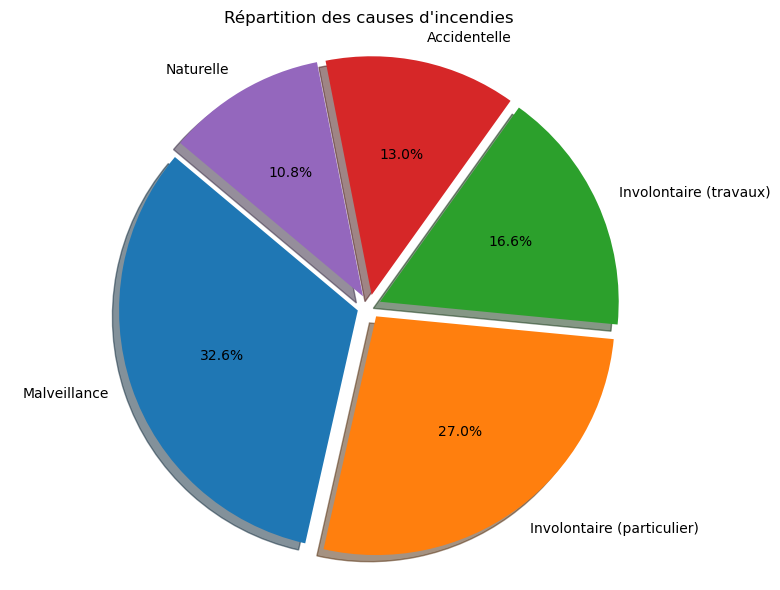

In [30]:
causes = df_merge['Nature'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(causes.values, labels=causes.index,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05]*len(causes))

plt.title("Répartition des causes d'incendies")
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Test de cluster avec DBScan

In [31]:
# 1. Grouper pour compter la fréquence d'apparition
commune_counts = df_merge.groupby(['Nom de la commune', 'latitude', 'longitude']).size().reset_index(name='frequence')

# 2. Répliquer les lignes selon la fréquence (pondération par duplication)
df_expanded = commune_counts.loc[commune_counts.index.repeat(commune_counts['frequence'])].reset_index(drop=True)

X = df_expanded[['latitude', 'longitude']]

In [32]:
coords_rad = np.radians(df_expanded[['latitude', 'longitude']])
kms_per_radian = 6371.0088
eps_km = 5
eps = eps_km / kms_per_radian
db = DBSCAN(eps=eps, min_samples=20, metric='haversine').fit(coords_rad)
df_expanded['cluster'] = db.labels_

In [33]:
fig = px.scatter_mapbox(

        df_expanded[df_expanded.cluster != -1],
        lat="latitude",
        lon="longitude",
        color="cluster",
        hover_name="Nom de la commune",
        title="Clusters d'incendies en France (2006-2024)",
        zoom=5,
        height = 1000,        mapbox_style="carto-positron"
)

fig.show()

### Tests sur la ville d'Ajaccio

In [34]:
mask = df_merge['Nom de la commune'] == 'Ajaccio'
pd.set_option('display.max_rows', None)
df_ajaccio = df_merge[mask]
df_ajaccio.head(10)

Département Code INSEE Nom de la commune  Surface parcourue (m2)  \
57            2A      2A004           Ajaccio                     400   
579           2A      2A004           Ajaccio                     500   
586           2A      2A004           Ajaccio                    1000   
875           2A      2A004           Ajaccio                      40   
945           2A      2A004           Ajaccio                     100   
971           2A      2A004           Ajaccio                      20   
1063          2A      2A004           Ajaccio                     400   
1446          2A      2A004           Ajaccio                     350   
1479          2A      2A004           Ajaccio                      75   
1531          2A      2A004           Ajaccio                     800   

      Surface forêt (m2)   latitude  longitude  Surface maquis garrigues (m2)  \
57                   NaN  41.926399   8.737603                            NaN   
579                  NaN  41.926399   8.737603                            NaN   
586                  NaN  41.926399   8.737603                            NaN   
875                  NaN  41.926399   8.737603                           40.0   
945                  NaN  41.926399   8.737603                          100.0   
971                  NaN  41.926399   8.737603                           20.0   
1063                 NaN  41.926399   8.737603                          400.0   
1446                 NaN  41.926399   8.737603                          350.0   
1479                 NaN  41.926399   8.737603                           75.0   
1531                 NaN  41.926399   8.737603                          800.0   

      Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
57                                           NaN                      NaN   
579                                          NaN                      NaN   
586                                          NaN                      NaN   
875                                          NaN                      NaN   
945                                          NaN                      NaN   
971                                          NaN                      NaN   
1063                                         NaN                      NaN   
1446                                         NaN                      NaN   
1479                                         NaN                      NaN   
1531                                         NaN                      NaN   

      Autres surfaces (m2)  Surface autres terres boisées (m2)  \
57                     NaN                                 NaN   
579                    NaN                                 NaN   
586                    NaN                                 NaN   
875                    NaN                                 NaN   
945                    NaN                                 NaN   
971                    NaN                                 NaN   
1063                   NaN                                 NaN   
1446                   NaN                                 NaN   
1479                   NaN                                 NaN   
1531                   NaN                                 NaN   

      Surfaces non boisées naturelles (m2)  \
57                                     NaN   
579                                    NaN   
586                                    NaN   
875                                    NaN   
945                                    NaN   
971                                    NaN   
1063                                   NaN   
1446                                   NaN   
1479                                   NaN   
1531                                   NaN   

      Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
57                                          NaN                        NaN   
579                                         NaN                        

In [35]:
mask = df_ajaccio['année'] == 2024
df_ajaccio_2024 = df_ajaccio[mask]
df_ajaccio_2024.head(10)

Département Code INSEE Nom de la commune  Surface parcourue (m2)  \
28485          2A      2A004           Ajaccio                       4   
28864          2A      2A004           Ajaccio                    1200   
28924          2A      2A004           Ajaccio                      25   
29127          2A      2A004           Ajaccio                   24000   
29318          2A      2A004           Ajaccio                      10   
29319          2A      2A004           Ajaccio                      20   

       Surface forêt (m2)   latitude  longitude  \
28485                 0.0  41.926399   8.737603   
28864                 0.0  41.926399   8.737603   
28924                 0.0  41.926399   8.737603   
29127                 0.0  41.926399   8.737603   
29318                 0.0  41.926399   8.737603   
29319                 0.0  41.926399   8.737603   

       Surface maquis garrigues (m2)  \
28485                            4.0   
28864                         1200.0   
28924                           25.0   
29127                        24000.0   
29318                           10.0   
29319                           20.0   

       Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
28485                                         0.0                      0.0   
28864                                         0.0                      0.0   
28924                                         0.0                      0.0   
29127                                         0.0                      0.0   
29318                                         0.0                      0.0   
29319                                         0.0                      0.0   

       Autres surfaces (m2)  Surface autres terres boisées (m2)  \
28485                   0.0                                 NaN   
28864                   0.0                                 NaN   
28924                   0.0                                 NaN   
29127                   0.0                                 NaN   
29318                   0.0                                 NaN   
29319                   0.0                                 NaN   

       Surfaces non boisées naturelles (m2)  \
28485                                   NaN   
28864                                   NaN   
28924                                   NaN   
29127                                   NaN   
29318                                   NaN   
29319                                   NaN   

       Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
28485                                        NaN                        NaN   
28864                                        NaN                        NaN   
28924                                        NaN                        NaN   
29127                                        NaN                        NaN   
29318                                        NaN                        NaN   
29319                                        NaN                        NaN   

       Type de peuplement                      Nature  année  mois  jour  \
28485                 NaN                         NaN   2024     2    20   
28864                 NaN  Involontaire (particulier)   2024     6    26   
28924                 NaN                         NaN   2024     7     8   
29127                 NaN  Involontaire (particulier)   2024     8     1   
29318                 NaN                Accidentelle   2024     8    15   
29319                 NaN                Accidentelle   2024     8    15   

       heure  
28485      9  
28864     17  
28924     16  
29127     15  
29318     12  
29319     12

In [36]:
df_ajaccio_2024['Département'] = 20
df_ajaccio_2024

C:\Users\joelt\AppData\Local\Temp\ipykernel_16088\2707522432.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Département Code INSEE Nom de la commune  Surface parcourue (m2)  \
28485           20      2A004           Ajaccio                       4   
28864           20      2A004           Ajaccio                    1200   
28924           20      2A004           Ajaccio                      25   
29127           20      2A004           Ajaccio                   24000   
29318           20      2A004           Ajaccio                      10   
29319           20      2A004           Ajaccio                      20   

       Surface forêt (m2)   latitude  longitude  \
28485                 0.0  41.926399   8.737603   
28864                 0.0  41.926399   8.737603   
28924                 0.0  41.926399   8.737603   
29127                 0.0  41.926399   8.737603   
29318                 0.0  41.926399   8.737603   
29319                 0.0  41.926399   8.737603   

       Surface maquis garrigues (m2)  \
28485                            4.0   
28864                         1200.0   
28924                           25.0   
29127                        24000.0   
29318                           10.0   
29319                           20.0   

       Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
28485                                         0.0                      0.0   
28864                                         0.0                      0.0   
28924                                         0.0                      0.0   
29127                                         0.0                      0.0   
29318                                         0.0                      0.0   
29319                                         0.0                      0.0   

       Autres surfaces (m2)  Surface autres terres boisées (m2)  \
28485                   0.0                                 NaN   
28864                   0.0                                 NaN   
28924                   0.0                                 NaN   
29127                   0.0                                 NaN   
29318                   0.0                                 NaN   
29319                   0.0                                 NaN   

       Surfaces non boisées naturelles (m2)  \
28485                                   NaN   
28864                                   NaN   
28924                                   NaN   
29127                                   NaN   
29318                                   NaN   
29319                                   NaN   

       Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
28485                                        NaN                        NaN   
28864                                        NaN                        NaN   
28924                                        NaN                        NaN   
29127                                        NaN                        NaN   
29318                                        NaN                        NaN   
29319                                        NaN                        NaN   

       Type de peuplement                      Nature  année  mois  jour  \
28485                 NaN                         NaN   2024     2    20   
28864                 NaN  Involontaire (particulier)   2024     6    26   
28924                 NaN                         NaN   2024     7     8   
29127                 NaN  Involontaire (particulier)   2024     8     1   
29318                 NaN                Accidentelle   2024     8    15   
29319                 NaN                Accidentelle   2024     8    15   

       heure  
28485      9  
28864     17  
28924     16  
29127     15  
29318     12  
29319     12

In [37]:
# Rajout d'une colonne pour indiquer les feux
df_ajaccio_2024['Feux']=1
df_ajaccio_2024

C:\Users\joelt\AppData\Local\Temp\ipykernel_16088\3900143563.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Département Code INSEE Nom de la commune  Surface parcourue (m2)  \
28485           20      2A004           Ajaccio                       4   
28864           20      2A004           Ajaccio                    1200   
28924           20      2A004           Ajaccio                      25   
29127           20      2A004           Ajaccio                   24000   
29318           20      2A004           Ajaccio                      10   
29319           20      2A004           Ajaccio                      20   

       Surface forêt (m2)   latitude  longitude  \
28485                 0.0  41.926399   8.737603   
28864                 0.0  41.926399   8.737603   
28924                 0.0  41.926399   8.737603   
29127                 0.0  41.926399   8.737603   
29318                 0.0  41.926399   8.737603   
29319                 0.0  41.926399   8.737603   

       Surface maquis garrigues (m2)  \
28485                            4.0   
28864                         1200.0   
28924                           25.0   
29127                        24000.0   
29318                           10.0   
29319                           20.0   

       Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
28485                                         0.0                      0.0   
28864                                         0.0                      0.0   
28924                                         0.0                      0.0   
29127                                         0.0                      0.0   
29318                                         0.0                      0.0   
29319                                         0.0                      0.0   

       Autres surfaces (m2)  Surface autres terres boisées (m2)  \
28485                   0.0                                 NaN   
28864                   0.0                                 NaN   
28924                   0.0                                 NaN   
29127                   0.0                                 NaN   
29318                   0.0                                 NaN   
29319                   0.0                                 NaN   

       Surfaces non boisées naturelles (m2)  \
28485                                   NaN   
28864                                   NaN   
28924                                   NaN   
29127                                   NaN   
29318                                   NaN   
29319                                   NaN   

       Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
28485                                        NaN                        NaN   
28864                                        NaN                        NaN   
28924                                        NaN                        NaN   
29127                                        NaN                        NaN   
29318                                        NaN                        NaN   
29319                                        NaN                        NaN   

       Type de peuplement                      Nature  année  mois  jour  \
28485                 NaN                         NaN   2024     2    20   
28864                 NaN  Involontaire (particulier)   2024     6    26   
28924                 NaN                         NaN   2024     7     8   
29127                 NaN  Involontaire (particulier)   2024     8     1   
29318                 NaN                Accidentelle   2024     8    15   
29319                 NaN                Accidentelle   2024     8    15   

       heure  Feux  
28485      9     1  
28864     17     1  
28924     16     1  
29127     15     1  
29318     12     1  
29319     12     1

In [38]:
df_ajaccio_2024['Feux'].replace(np.nan, 0, inplace=True)
df_ajaccio_2024.head()

C:\Users\joelt\AppData\Local\Temp\ipykernel_16088\3763100105.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\joelt\AppData\Local\Temp\ipykernel_16088\3763100105.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Département Code INSEE Nom de la commune  Surface parcourue (m2)  \
28485           20      2A004           Ajaccio                       4   
28864           20      2A004           Ajaccio                    1200   
28924           20      2A004           Ajaccio                      25   
29127           20      2A004           Ajaccio                   24000   
29318           20      2A004           Ajaccio                      10   

       Surface forêt (m2)   latitude  longitude  \
28485                 0.0  41.926399   8.737603   
28864                 0.0  41.926399   8.737603   
28924                 0.0  41.926399   8.737603   
29127                 0.0  41.926399   8.737603   
29318                 0.0  41.926399   8.737603   

       Surface maquis garrigues (m2)  \
28485                            4.0   
28864                         1200.0   
28924                           25.0   
29127                        24000.0   
29318                           10.0   

       Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
28485                                         0.0                      0.0   
28864                                         0.0                      0.0   
28924                                         0.0                      0.0   
29127                                         0.0                      0.0   
29318                                         0.0                      0.0   

       Autres surfaces (m2)  Surface autres terres boisées (m2)  \
28485                   0.0                                 NaN   
28864                   0.0                                 NaN   
28924                   0.0                                 NaN   
29127                   0.0                                 NaN   
29318                   0.0                                 NaN   

       Surfaces non boisées naturelles (m2)  \
28485                                   NaN   
28864                                   NaN   
28924                                   NaN   
29127                                   NaN   
29318                                   NaN   

       Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
28485                                        NaN                        NaN   
28864                                        NaN                        NaN   
28924                                        NaN                        NaN   
29127                                        NaN                        NaN   
29318                                        NaN                        NaN   

       Type de peuplement                      Nature  année  mois  jour  \
28485                 NaN                         NaN   2024     2    20   
28864                 NaN  Involontaire (particulier)   2024     6    26   
28924                 NaN                         NaN   2024     7     8   
29127                 NaN  Involontaire (particulier)   2024     8     1   
29318                 NaN                Accidentelle   2024     8    15   

       heure  Feux  
28485      9     1  
28864     17     1  
28924     16     1  
29127     15     1  
29318     12     1

#### Rajout de la météo

In [39]:
df_meteo=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/Meteo_ajaccio_cleaned.csv', sep=';', encoding='utf-8')
df_meteo.head(10)

DATE   RR    DRR    TN     HTN    TX   HTX    TM   TMNX  TNSOL  TN50  \
0  2024-01-01  0.0    0.0   6.9   721.0  16.0  1131  10.2  11.45    6.1   6.5   
1  2024-01-02  0.4   32.0   5.2   626.0  15.5  1255  10.5  10.35    4.2   4.5   
2  2024-01-03  0.0    NaN  10.9  1905.0  17.6  1232  13.5  14.25    8.5  10.2   
3  2024-01-04  1.2  150.0   7.2   701.0  17.7  1114  10.9  12.45    6.0   6.5   
4  2024-01-05  5.2  480.0   7.7    28.0  14.5  1704  11.9  11.10    6.1   6.8   
5  2024-01-06  3.4  286.0   9.7   604.0  17.0  1304  12.2  13.35    8.7   9.1   
6  2024-01-07  0.0    0.0   9.2   751.0  13.5  1240  10.1  11.35    8.4   8.7   
7  2024-01-08  0.0   33.0   6.8    47.0  13.5  1233  10.0  10.15    5.6   6.0   
8  2024-01-09  0.0  205.0   8.2   344.0  12.2  1335  10.3  10.20    7.3   7.5   
9  2024-01-10  2.6  285.0   9.4   735.0  14.8  1135  11.1  12.10    8.6   8.7   

   TAMPLI  TNTXM  FFM   FXI  DXI   HXI  FXY  DXY   HXY  FXI3S  HXI3S  UN  \
0     9.1   11.5  2.7   8.8  310  1334  4.8  310  1333    8.2   1334  57   
1    10.3   10.4  2.6   6.5   20     3  4.5   20   659    6.2     10  60   
2     6.7   14.3  3.1  12.5  210   246  9.1  210   252   11.8    246  66   
3    10.5   12.5  3.3   7.1  230  1331  5.8  230  1336    6.8   1331  50   
4     6.8   11.1  2.5   9.6  160  1753  5.6  160  1753    8.9   1753  71   
5     7.3   13.4  2.2  12.2  270  1708  6.5  300  1341   10.7   1710  65   
6     4.3   11.4  1.5   6.9  310  1335  3.6  330  1341    6.5   1337  54   
7     6.7   10.2  1.4   4.0   20  2307  2.8   50  2027    3.6   2019  66   
8     4.0   10.2  1.6   4.5   50   143  3.3   40   146    4.2    146  82   
9     5.4   12.1  1.6   5.6   10  2005  3.6   30  2008    5.4   2010  61   

      HUN  UX   HUX  DHUMI40  DHUMI80  TSVM  UM  ORAG  BRUME  ETPMON  \
0  1316.0  95   702        0    916.0  10.0  82   0.0    0.0     1.5   
1  1324.0  93   637        0   1093.0  10.4  82   0.0    0.0     1.0   
2  1304.0  96   217        0   1124.0  13.1  85   NaN    0.0     1.3   
3  1133.0  95   309        0    727.0  10.3  79   0.0    0.0     1.6   
4   122.0  97  2239        0   1246.0  12.5  89   0.0    0.0     0.3   
5  1601.0  98   521        0    904.0  11.9  84   0.0    0.0     1.6   
6  1226.0  97   808        0    891.0  10.2  83   0.0    0.0     1.2   
7  1201.0  95   159        0   1067.0  10.4  85   0.0    0.0     0.9   
8  1319.0  95  1012        0   1440.0  11.2  90   0.0    0.0     0.6   
9  1242.0  95     1        0   1083.0  11.1  85   0.0    0.0     1.2   

   ETPGRILLE  Département  
0        1.6           20  
1        1.3           20  
2        1.4           20  
3        2.0           20  
4        0.8           20  
5        1.4           20  
6        1.2           20  
7        1.1           20  
8        0.9           20  
9        1.3           20

In [40]:
df_meteo['DATE'] = pd.to_datetime(df_meteo['DATE'])
type(df_meteo['DATE'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [41]:
df_meteo['année'] = df_meteo['DATE'].dt.year
df_meteo['mois'] = df_meteo['DATE'].dt.month
df_meteo['jour'] = df_meteo['DATE'].dt.day


display(df_meteo.head(10))
pd.options.display.max_columns = None 
print()

DATE   RR    DRR    TN     HTN    TX   HTX    TM   TMNX  TNSOL  TN50  \
0 2024-01-01  0.0    0.0   6.9   721.0  16.0  1131  10.2  11.45    6.1   6.5   
1 2024-01-02  0.4   32.0   5.2   626.0  15.5  1255  10.5  10.35    4.2   4.5   
2 2024-01-03  0.0    NaN  10.9  1905.0  17.6  1232  13.5  14.25    8.5  10.2   
3 2024-01-04  1.2  150.0   7.2   701.0  17.7  1114  10.9  12.45    6.0   6.5   
4 2024-01-05  5.2  480.0   7.7    28.0  14.5  1704  11.9  11.10    6.1   6.8   
5 2024-01-06  3.4  286.0   9.7   604.0  17.0  1304  12.2  13.35    8.7   9.1   
6 2024-01-07  0.0    0.0   9.2   751.0  13.5  1240  10.1  11.35    8.4   8.7   
7 2024-01-08  0.0   33.0   6.8    47.0  13.5  1233  10.0  10.15    5.6   6.0   
8 2024-01-09  0.0  205.0   8.2   344.0  12.2  1335  10.3  10.20    7.3   7.5   
9 2024-01-10  2.6  285.0   9.4   735.0  14.8  1135  11.1  12.10    8.6   8.7   

   TAMPLI  TNTXM  FFM   FXI  DXI   HXI  FXY  DXY   HXY  FXI3S  HXI3S  UN  \
0     9.1   11.5  2.7   8.8  310  1334  4.8  310  1333    8.2   1334  57   
1    10.3   10.4  2.6   6.5   20     3  4.5   20   659    6.2     10  60   
2     6.7   14.3  3.1  12.5  210   246  9.1  210   252   11.8    246  66   
3    10.5   12.5  3.3   7.1  230  1331  5.8  230  1336    6.8   1331  50   
4     6.8   11.1  2.5   9.6  160  1753  5.6  160  1753    8.9   1753  71   
5     7.3   13.4  2.2  12.2  270  1708  6.5  300  1341   10.7   1710  65   
6     4.3   11.4  1.5   6.9  310  1335  3.6  330  1341    6.5   1337  54   
7     6.7   10.2  1.4   4.0   20  2307  2.8   50  2027    3.6   2019  66   
8     4.0   10.2  1.6   4.5   50   143  3.3   40   146    4.2    146  82   
9     5.4   12.1  1.6   5.6   10  2005  3.6   30  2008    5.4   2010  61   

      HUN  UX   HUX  DHUMI40  DHUMI80  TSVM  UM  ORAG  BRUME  ETPMON  \
0  1316.0  95   702        0    916.0  10.0  82   0.0    0.0     1.5   
1  1324.0  93   637        0   1093.0  10.4  82   0.0    0.0     1.0   
2  1304.0  96   217        0   1124.0  13.1  85   NaN    0.0     1.3   
3  1133.0  95   309        0    727.0  10.3  79   0.0    0.0     1.6   
4   122.0  97  2239        0   1246.0  12.5  89   0.0    0.0     0.3   
5  1601.0  98   521        0    904.0  11.9  84   0.0    0.0     1.6   
6  1226.0  97   808        0    891.0  10.2  83   0.0    0.0     1.2   
7  1201.0  95   159        0   1067.0  10.4  85   0.0    0.0     0.9   
8  1319.0  95  1012        0   1440.0  11.2  90   0.0    0.0     0.6   
9  1242.0  95     1        0   1083.0  11.1  85   0.0    0.0     1.2   

   ETPGRILLE  Département  année  mois  jour  
0        1.6           20   2024     1     1  
1        1.3           20   2024     1     2  
2        1.4           20   2024     1     3  
3        2.0           20   2024     1     4  
4        0.8           20   2024     1     5  
5        1.4           20   2024     1     6  
6        1.2           20   2024     1     7  
7        1.1           20   2024     1     8  
8        0.9           20   2024     1     9  
9        1.3           20   2024     1    10

In [42]:
df_corse = df_meteo.merge(df_ajaccio_2024,
                    on=["année", "mois", "jour"],
                    how="left")
df_corse.head(10)

DATE   RR    DRR    TN     HTN    TX   HTX    TM   TMNX  TNSOL  TN50  \
0 2024-01-01  0.0    0.0   6.9   721.0  16.0  1131  10.2  11.45    6.1   6.5   
1 2024-01-02  0.4   32.0   5.2   626.0  15.5  1255  10.5  10.35    4.2   4.5   
2 2024-01-03  0.0    NaN  10.9  1905.0  17.6  1232  13.5  14.25    8.5  10.2   
3 2024-01-04  1.2  150.0   7.2   701.0  17.7  1114  10.9  12.45    6.0   6.5   
4 2024-01-05  5.2  480.0   7.7    28.0  14.5  1704  11.9  11.10    6.1   6.8   
5 2024-01-06  3.4  286.0   9.7   604.0  17.0  1304  12.2  13.35    8.7   9.1   
6 2024-01-07  0.0    0.0   9.2   751.0  13.5  1240  10.1  11.35    8.4   8.7   
7 2024-01-08  0.0   33.0   6.8    47.0  13.5  1233  10.0  10.15    5.6   6.0   
8 2024-01-09  0.0  205.0   8.2   344.0  12.2  1335  10.3  10.20    7.3   7.5   
9 2024-01-10  2.6  285.0   9.4   735.0  14.8  1135  11.1  12.10    8.6   8.7   

   TAMPLI  TNTXM  FFM   FXI  DXI   HXI  FXY  DXY   HXY  FXI3S  HXI3S  UN  \
0     9.1   11.5  2.7   8.8  310  1334  4.8  310  1333    8.2   1334  57   
1    10.3   10.4  2.6   6.5   20     3  4.5   20   659    6.2     10  60   
2     6.7   14.3  3.1  12.5  210   246  9.1  210   252   11.8    246  66   
3    10.5   12.5  3.3   7.1  230  1331  5.8  230  1336    6.8   1331  50   
4     6.8   11.1  2.5   9.6  160  1753  5.6  160  1753    8.9   1753  71   
5     7.3   13.4  2.2  12.2  270  1708  6.5  300  1341   10.7   1710  65   
6     4.3   11.4  1.5   6.9  310  1335  3.6  330  1341    6.5   1337  54   
7     6.7   10.2  1.4   4.0   20  2307  2.8   50  2027    3.6   2019  66   
8     4.0   10.2  1.6   4.5   50   143  3.3   40   146    4.2    146  82   
9     5.4   12.1  1.6   5.6   10  2005  3.6   30  2008    5.4   2010  61   

      HUN  UX   HUX  DHUMI40  DHUMI80  TSVM  UM  ORAG  BRUME  ETPMON  \
0  1316.0  95   702        0    916.0  10.0  82   0.0    0.0     1.5   
1  1324.0  93   637        0   1093.0  10.4  82   0.0    0.0     1.0   
2  1304.0  96   217        0   1124.0  13.1  85   NaN    0.0     1.3   
3  1133.0  95   309        0    727.0  10.3  79   0.0    0.0     1.6   
4   122.0  97  2239        0   1246.0  12.5  89   0.0    0.0     0.3   
5  1601.0  98   521        0    904.0  11.9  84   0.0    0.0     1.6   
6  1226.0  97   808        0    891.0  10.2  83   0.0    0.0     1.2   
7  1201.0  95   159        0   1067.0  10.4  85   0.0    0.0     0.9   
8  1319.0  95  1012        0   1440.0  11.2  90   0.0    0.0     0.6   
9  1242.0  95     1        0   1083.0  11.1  85   0.0    0.0     1.2   

   ETPGRILLE  Département_x  année  mois  jour  Département_y Code INSEE  \
0        1.6             20   2024     1     1            NaN        NaN   
1        1.3             20   2024     1     2            NaN        NaN   
2        1.4             20   2024     1     3            NaN        NaN   
3        2.0             20   2024     1     4            NaN        NaN   
4        0.8             20   2024     1     5            NaN        NaN   
5        1.4             20   2024     1     6            NaN        NaN   
6        1.2             20   2024     1     7            NaN        NaN   
7        1.1             20   2024     1     8            NaN        NaN   
8        0.9             20   2024     1     9            NaN        NaN   
9        1.3             20   2024     1    10            NaN        NaN   

  Nom de la commune  Surface parcourue (m2)  Surface forêt (m2)  latitude  \
0               NaN                     NaN                 NaN       NaN   
1               NaN                     NaN                 NaN       NaN   
2               NaN                     NaN                 NaN       NaN   
3               NaN                     NaN                 NaN       NaN   
4               NaN                     NaN                 NaN       NaN   
5               NaN                     NaN                 NaN       NaN   
6               NaN                     NaN                 NaN       NaN   
7               NaN                     NaN 